参考：

- [一文教你如何用PyTorch构建 Faster RCNN](https://zhuanlan.zhihu.com/p/56710152)
- [深入解读Python解析XML的几种方式](http://www.codingpy.com/article/parsing-xml-using-python/)
- [Python 标准库之 xml.etree.ElementTree](http://www.cnblogs.com/ifantastic/archive/2013/04/12/3017110.html)

In [1]:
cd ../app/detection/

D:\API\CVX\app\detection


In [5]:
from anchor import RPNAnchorGenerator

In [6]:
cd ../..

D:\API\CVX


In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch

利用 `plt` 载入图片：

(479, 640, 3)


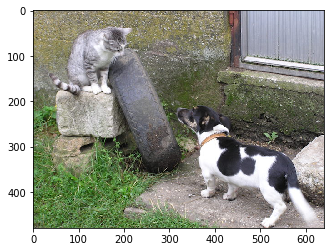

In [8]:
img = plt.imread('data/images/catdog.jpg')
plt.imshow(img);
print(img.shape)

将 Numpy 数组转换为 Torch 的 tensor：

torch.Size([3, 640, 479])


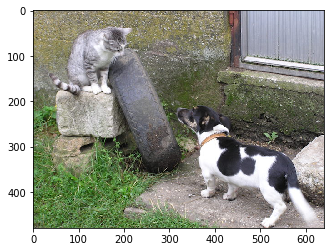

In [9]:
x = torch.tensor(img.astype('float32').transpose((2, 1, 0)))  # channel first

plt.imshow(x.numpy().transpose((2, 1, 0)).astype('B'));
print(x.shape)

In [10]:
# 注意坐标轴原点是图片的左上角。bbox 是 bounding box 的缩写。
dog_bbox = [300, 200, 625, 475]
cat_bbox = [30, 30, 230, 200]

# [y1, x1, y2, x2] format
labels = torch.LongTensor([1, 2])  # 0 represents background

下面画出图像与边界框：

In [11]:
def bbox_to_rect(bbox, color):
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

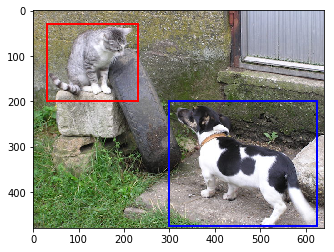

In [12]:
fig, ax = plt.subplots()
plt.imshow(img)
ax.add_patch(bbox_to_rect(dog_bbox, 'blue'))
ax.add_patch(bbox_to_rect(cat_bbox, 'red'))
ax.autoscale_view();

为了可以 resize 到相同的尺寸，下面我们使用 PIL：

In [13]:
from PIL import Image
img = Image.open('data/images/catdog.jpg').resize((800, 800))
img.size

(800, 800)

载入基网络：

In [14]:
import torchvision
model = torchvision.models.vgg16(pretrained=True)
for layer in model.features:
    print(layer)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(512, 512, kernel_size=(3, 3), stride

In [15]:
import numpy as np
x = torch.tensor(np.array(img, dtype='float32').transpose((2, 1, 0)))  # channel first
x = x.unsqueeze(0)
x.shape

torch.Size([1, 3, 800, 800])

In [16]:
req_features = []
k = x.clone()
for i in model.features:
    k = i(k)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features))  # 30
print(out_channels)  # 512

30
512


In [17]:
faster_rcnn_fe_extractor = torch.nn.Sequential(*req_features)

In [18]:
out_map = faster_rcnn_fe_extractor(x)
print(out_map.size())

torch.Size([1, 512, 50, 50])


In [35]:
scales = [8, 16, 32]  # 尺度，面积比
ratios = [0.5, 1, 2]  # 高宽比率（aspect ratios）
base_size = 16
stride = 16
alloc_size = out_map.size()[2:]
base_anchors = RPNAnchorGenerator(
    stride, base_size, ratios, scales, alloc_size).anchors
base_anchors

array([[[[[ -84.,  -40.,   99., ..., -344.,  183.,  359.],
          [ -68.,  -40.,  115., ..., -344.,  199.,  359.],
          [ -52.,  -40.,  131., ..., -344.,  215.,  359.],
          ...,
          [ 668.,  -40.,  851., ..., -344.,  935.,  359.],
          [ 684.,  -40.,  867., ..., -344.,  951.,  359.],
          [ 700.,  -40.,  883., ..., -344.,  967.,  359.]],

         [[ -84.,  -24.,   99., ..., -328.,  183.,  375.],
          [ -68.,  -24.,  115., ..., -328.,  199.,  375.],
          [ -52.,  -24.,  131., ..., -328.,  215.,  375.],
          ...,
          [ 668.,  -24.,  851., ..., -328.,  935.,  375.],
          [ 684.,  -24.,  867., ..., -328.,  951.,  375.],
          [ 700.,  -24.,  883., ..., -328.,  967.,  375.]],

         [[ -84.,   -8.,   99., ..., -312.,  183.,  391.],
          [ -68.,   -8.,  115., ..., -312.,  199.,  391.],
          [ -52.,   -8.,  131., ..., -312.,  215.,  391.],
          ...,
          [ 668.,   -8.,  851., ..., -312.,  935.,  391.],
       

In [42]:
anchors = base_anchors.reshape((-1, 4))

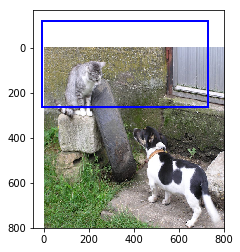

In [45]:
fig, ax = plt.subplots()
plt.imshow(img)
ax.add_patch(bbox_to_rect(anchors[2000], 'blue'))
ax.autoscale_view();

In [50]:
inside_index = np.where(
       (anchors[:, 0] >= 0) &
       (anchors[:, 1] >= 0) &
       (anchors[:, 2] <= 800) &
       (anchors[:, 3] <= 800)
   )[0]
print(inside_index.shape)

(9132,)


In [51]:
label = np.empty((len(inside_index), ), dtype=np.int32)
label.fill(-1)
print(label.shape)

(9132,)


In [116]:
valid_anchors= anchors[inside_index]
print(valid_anchors.shape)

(9132, 4)


In [55]:
class Anchor:
    def __init__(self, base_size=16):
        self.base_size = base_size  # 滑动窗口的大小
        if not base_size:
            raise ValueError("Invalid base_size: {}.".format(base_size))
        self._anchor = np.array([1, 1, self.base_size, self.base_size]) - 1

    @property
    def anchor(self):
        return self._anchor

    @anchor.setter
    def anchor(self, new_anchor):
        self._anchor = new_anchor

    @property
    def w(self):
        '''
        锚框的宽度
        '''
        return self.anchor[2] - self.anchor[0] + 1

    @property
    def h(self):
        '''
        锚框的高度
        '''
        return self.anchor[3] - self.anchor[1] + 1

    @property
    def size(self):
        '''
        锚框的面积
        '''
        return self.w * self.h

    @property
    def _whctrs(self):
        """
        Return x center, and y center for an anchor (window). 锚框的中心坐标
        """
        x_ctr = self.anchor[0] + 0.5 * (self.w - 1)
        y_ctr = self.anchor[1] + 0.5 * (self.h - 1)
        return np.array([x_ctr, y_ctr])

    @staticmethod
    def _coordinate(aspect, ctr):
        '''
        依据宽高组合计算锚框的坐标
        '''
        k = (aspect - 1) / 2
        return np.concatenate([ctr - k, ctr + k], axis=1)




In [131]:
anchor, anchor1 = valid_anchor_boxes[:2]

In [136]:
import d2lzh as d2l

ModuleNotFoundError: No module named 'd2lzh'

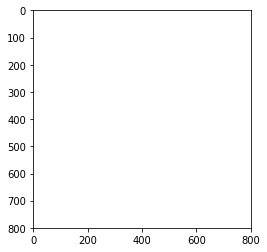

In [114]:
iou(*valid_anchor_boxes[:2])

0.8151364126804707

In [117]:
bbox = anchors
ious = np.empty((len(valid_anchors), 2), dtype=np.float32)
ious.fill(0)
print(bbox)
for num1, i in enumerate(valid_anchors):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)

        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * \
                (inter_x2 - inter_x1)
            iou = iter_area / \
                (anchor_area + box_area - iter_area)
        else:
            iou = 0.

        ious[num1, num2] = iou
print(ious.shape)

[[ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 ...
 [ 748.  704.  835.  879.]
 [ 704.  616.  879.  967.]
 [ 616.  440.  967. 1143.]]


IndexError: index 2 is out of bounds for axis 1 with size 2